# Multi-Label Wine Quality Classification


---







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Context & Workflow in Mind
The dataset is pulled through Kaggle API. The dataset is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009].

### **Tools & Models**


**The plan** is to use the dataset to train some multi-label classification models using different ML models and compare their: 

*   Logistic regression
*   SVM
*   Kernel SVM (Poly)
*   K-NN



### **Workflow**

*   Import libraries & data
*   Exploratory analysis & Data visualization
*   Data preprocessing
*   Rapid prototyping (train on quickly preprocessed raw data)
*   Feature engineering
*   Iterate for better performance (metric: precision/recall & F score)

## Import Libararies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# oversampling
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import  SelectKBest
from sklearn.feature_selection import  chi2

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



## Importing Dataset

In [ ]:
wine_df = pd.read_csv("./drive/My Drive/Multi-label Wine Quality Classification/winequality-red.csv")
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
wine_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [ ]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Exploratory Analysis & Data Visualizations

### Skewed Classes

Text(0.5, 8.95999999999998, 'wine quality')

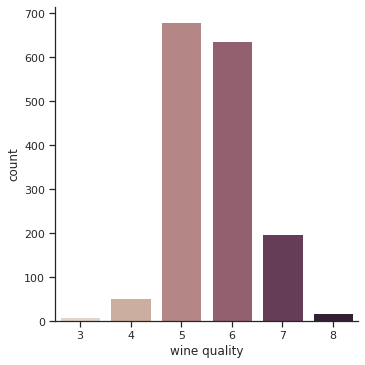

In [ ]:
# Visualize the categorical labels first
sns.set(style="ticks", color_codes=True)

sns.catplot(x="quality", kind="count", palette="ch:.25", data=wine_df);
plt.xlabel('wine quality')

In [ ]:
wine_df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Note that the classes are pretty unenvenly distributed. There are much more normal wines than excellent or poor ones (Need to research more on how to deal with situation). In general seems we got 6 categaories in here from grading 3 - 8.

### Correlation Analysis

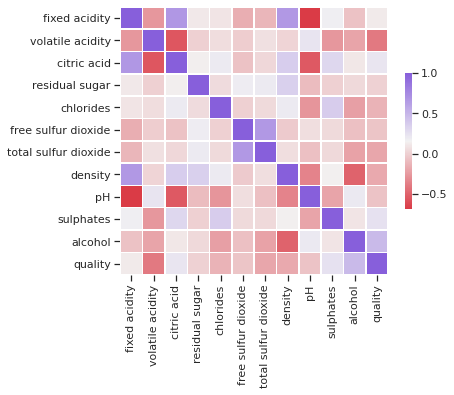

In [ ]:
corr = wine_df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(6, 5))
cmap = sns.diverging_palette(10, 275, as_cmap=True)

sns.heatmap(corr, cmap=cmap, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)

Seems PH and fixed acidity, citric acid and PH/volatile acidity have high negtive correlation. Later we can consider to combine these features by apply principal component analysis (PCA). However, for now let's get something quick and dirty working first. However it may be helpful to plot the xy scattet plots for better visualization of the correlations between different features.

### Plotting Features w.r.t. Labels (Wine Quality)

A bar plot represents an estimate of central tendency for a numeric variable with the height of each rectangle and provides some indication of the uncertainty around that estimate using error bars.

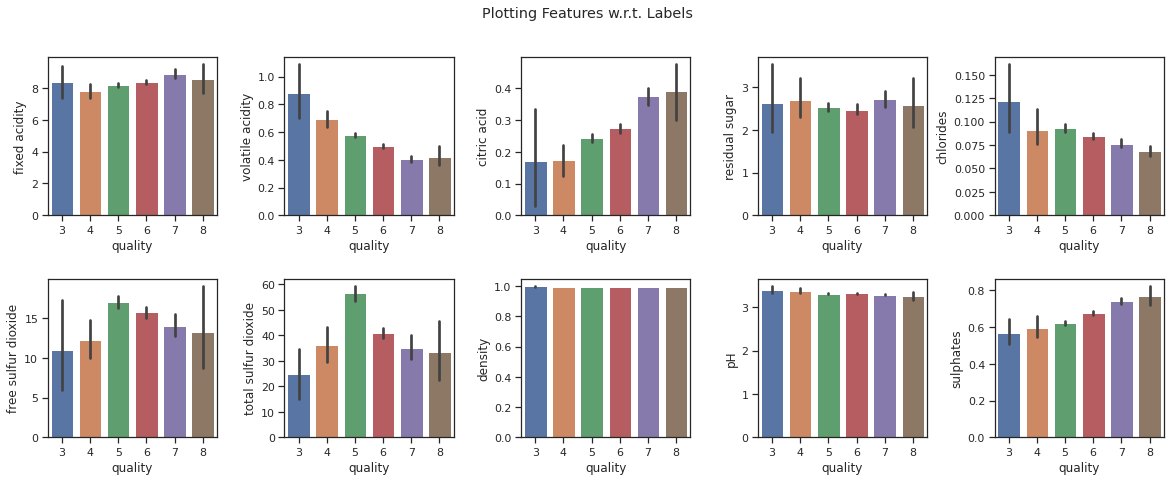

In [ ]:
# Creating a 2 x 5 subplot grid
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,7))
figure.suptitle("Plotting Features w.r.t. Labels")
# wspace: the amount of width reserved for space between subplots, expressed as a fraction of the average axis width
# hspace; the amount of height reserved for space between subplots, expressed as a fraction of the average axis height
figure.subplots_adjust(hspace=0.4, wspace= 0.4)

# Using for loop to interate through different features and plot its barplot against wine "quality" feature (categorical data)
for i in range(2):
  for j in range(5):
    sns.barplot(ax=axes[i,j], x='quality', y=wine_df.columns[i*5 + j], data = wine_df)


From the barplots above we see features like "fixed acidity", "residual sugar", "density", "PH" have almost no effect on predicting the quality of wine. We'll take out feature "density" in here since it does not have any correlation wrt wine quality.

## Data Preprocessing

### Feature Seletion (Univarite selection)

In [ ]:
from sklearn.feature_selection import  SelectKBest
from sklearn.feature_selection import  chi2

#apply SelectKBest class to extract top 10 best features
best_features = SelectKBest(score_func = chi2, k = 10)
fit = best_features.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                   Specs        Score
6   total sulfur dioxide  2755.557984
5    free sulfur dioxide   161.936036
10               alcohol    46.429892
1       volatile acidity    15.580289
2            citric acid    13.025665
0          fixed acidity    11.260652
9              sulphates     4.558488
3         residual sugar     4.123295
4              chlorides     0.752426
8                     pH     0.154655


### Drop irrelevant features

We'll drop "density" column as we discussed in the exploratory analysis section and keep the rest data the same. We will also drops 'sulphates', 'residual sugar', 'chlorides', 'pH' which scored less than 10

In [ ]:
wine_df = wine_df.drop(labels=['density','sulphates', 'residual sugar', 'chlorides', 'pH'], axis=1)
wine_df.head()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,alcohol,quality
0,7.4,0.70,0.00,11.0,34.0,9.4,5
1,7.8,0.88,0.00,25.0,67.0,9.8,5
2,7.8,0.76,0.04,15.0,54.0,9.8,5
3,11.2,0.28,0.56,17.0,60.0,9.8,6
4,7.4,0.70,0.00,11.0,34.0,9.4,5


In [ ]:
X = wine_df.iloc[:, :-1]
y = wine_df.iloc[:, -1]
print("the dimension of X training examples is:" + str(X.shape) + "\n the dimension of y training examples is:" + str(y.shape))

the dimension of X training examples is:(1599, 6)
 the dimension of y training examples is:(1599,)


Initial thought was one-hot encode wine quality and train 6 binary classification models to apply one vs. all. However, sklearn has the parameter in their classification fit methods that allows categorical multi-label classes. Let them do the work then.

### Splitting into Training/Test Sets

In [ ]:
# Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
print("The shape of splitted X_train set is:")
print(X_train.shape)
print(type(X_train))

The shape of splitted X_train set is:
(1119, 6)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Note the training samples (random indices) were randomly selected
X_train.head()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,alcohol
126,8.2,1.330,0.00,3.0,12.0,10.9
810,7.3,0.490,0.10,4.0,14.0,10.5
635,8.7,0.840,0.00,24.0,33.0,9.7
598,8.5,0.585,0.18,5.0,30.0,9.8
880,9.2,0.560,0.18,10.0,21.0,9.9


### SMOTE (Synthetic Minortity Oversampling Technique)

SMOTE works by utilizing a k-nearest neighbor algorithm to create synthetic data. SMOTE first start by choosing random data from the minority class, then k-nearest neighbors from the data are set. Synthetic data would then made between the random data and the randomly selected k-nearest neighbor. Note we only oversampling the minority classes on our training set, not test set.

In [ ]:
# Our goal to is oversample wine quality 3,4,6,7,8 to have the same samples as the most common wine quality (label) 5 i.e. 456 samples
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the wine quality array:")
y_train.value_counts()

Frequency of unique values of the wine quality array:


5    474
6    443
7    147
4     32
8     15
3      8
Name: quality, dtype: int64

In [ ]:
# oversampling the training data not test data
smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(wine_df[['fixed acidity', 'volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol']], wine_df['quality'])

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
freq = dict(zip(unique, counts))
print ("Frequency of wine quality after oversampling with SMOTE:")
for key, value in freq.items():
    print(f'{key}  {value}')

Frequency of wine quality after oversampling with SMOTE:
3  681
4  681
5  681
6  681
7  681
8  681


### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_tranform call .fit() to compute the mean and std deviation for later use 
# Note: the return type of .fit_transform is ndarray
X_train = scaler.fit_transform(X_train)
# No need to call fit_transform again since the params have been computed in the previous line
X_test = scaler.transform(X_test)

In [ ]:
print(X_train.shape)
print(type(X_train))

(4086, 6)
<class 'numpy.ndarray'>


## Trian Models

### Logistic Regression




In [ ]:
from sklearn.linear_model import LogisticRegression

# No params are passing in here into the LogisticRegression class (i.e. no tuning)
logReg_clf = LogisticRegression(random_state = 0, multi_class='ovr', max_iter=10000).fit(X_train, y_train)
y_pred_log = logReg_clf.predict(X_test)
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           3       0.05      1.00      0.10         2
           4       0.12      0.33      0.18        21
           5       0.67      0.58      0.62       207
           6       0.64      0.26      0.37       195
           7       0.27      0.37      0.31        52
           8       0.04      0.67      0.07         3

    accuracy                           0.42       480
   macro avg       0.30      0.53      0.27       480
weighted avg       0.58      0.42      0.46       480



### SVM

In [ ]:
# linear SVM 
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(random_state = 0, multi_class='ovr', max_iter=10000, class_weight=None).fit(X_train, y_train)

# kernel SVM 
from sklearn.svm import SVC
kernel_svm_clf = SVC(random_state=0, kernel = 'poly', decision_function_shape='ovr', max_iter=-1, class_weight=None).fit(X_train, y_train)

# predit the test data and generating report
y_pred_svm = svm_clf.predict(X_test)
y_pred_kernel_svm = kernel_svm_clf.predict(X_test)
print(classification_report(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_kernel_svm))

              precision    recall  f1-score   support

           3       0.04      1.00      0.08         2
           4       0.22      0.33      0.26        21
           5       0.64      0.66      0.65       207
           6       0.65      0.15      0.25       195
           7       0.21      0.27      0.24        52
           8       0.04      1.00      0.07         3

    accuracy                           0.40       480
   macro avg       0.30      0.57      0.26       480
weighted avg       0.57      0.40      0.42       480

              precision    recall  f1-score   support

           3       0.13      1.00      0.24         2
           4       0.14      0.48      0.22        21
           5       0.71      0.49      0.58       207
           6       0.60      0.51      0.55       195
           7       0.43      0.46      0.44        52
           8       0.11      1.00      0.19         3

    accuracy                           0.50       480
   macro avg       0.35

### K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=6)
knn_clf.fit(X_train, y_train)

# predit the test data and generating report
y_pred_knn = knn_clf.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           3       0.25      1.00      0.40         2
           4       0.29      0.95      0.44        21
           5       0.80      0.71      0.75       207
           6       0.83      0.49      0.62       195
           7       0.58      0.85      0.69        52
           8       0.12      1.00      0.22         3

    accuracy                           0.65       480
   macro avg       0.48      0.83      0.52       480
weighted avg       0.76      0.65      0.67       480



## Predicting the Test Set Results

The f1-score gives us the harmonic mean of precision and recall. The scores corresponding to every class will tell us the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.

The support is the number of samples we have for each class.

Since we have severly skewed classes. Accuracy may not be a good choice of metric of measuring the model performance. We'll use F1-score as our metric.



